# Support Intelligence & Risk Monitoring — Modeling Baselines (T4, Improved)

This notebook trains and evaluates **strong baseline models** for an operational support system:

1) **Ticket triage** into business categories: **Billing / Bug / Account / Other** (`category_mapped`)  
2) **Priority prediction**: **low / medium / high** (`priority_norm`)

The emphasis is on a **production-friendly** approach:
- fast training & inference (CPU-friendly)
- interpretable signals (text + metadata)
- easy to deploy behind an API or as a batch job for monitoring

---

## Inputs
Expected output of T3 in:
- `data/processed/tickets_clean_en.csv` *(recommended; works everywhere)*  
- `data/processed/tickets_clean_en.parquet` *(optional; requires pyarrow/fastparquet)*

Key columns used:
- Text: `message`, `tags_str`
- Metadata: `queue`, `type`
- Numeric: `body_len`, `n_tags`
- Targets: `category_mapped`, `priority_norm`

---

## Why the “improved” baseline?
In T3, `category_mapped` was created using **queue/tags/message rules**.  
A text-only model (message only) is therefore under-informed.

This improved baseline uses a **ColumnTransformer** that combines:
- TF‑IDF on `message`
- TF‑IDF on `tags_str`
- One-hot encoding for `queue` and `type`
- Numeric features (`body_len`, `n_tags`)

---

## Outputs
- Metrics: **F1-macro**, confusion matrices, classification reports
- Saved artifacts:
  - `models/t4_category_pipeline.joblib`
  - `models/t4_priority_pipeline.joblib`


## 0) Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    ConfusionMatrixDisplay
)

import joblib


## 1) Load cleaned dataset (T3)

In [2]:
DATA_DIR = "data/processed"
CSV_PATH = os.path.join(DATA_DIR, "tickets_clean_en.csv")
PARQUET_PATH = os.path.join(DATA_DIR, "tickets_clean_en.parquet")

df = None

# Prefer CSV (most reliable across environments)
if os.path.exists(CSV_PATH):
    print("Loading CSV:", CSV_PATH)
    df = pd.read_csv(CSV_PATH)
elif os.path.exists(PARQUET_PATH):
    print("Loading Parquet:", PARQUET_PATH)
    # Parquet may fail if pyarrow/fastparquet not installed
    df = pd.read_parquet(PARQUET_PATH)
else:
    raise FileNotFoundError(
        "Could not find T3 output. Please run the T3 notebook and export to "
        f"{CSV_PATH} (recommended) or {PARQUET_PATH}."
    )

print("Loaded shape:", df.shape)
df.head(3)


Loading CSV: data/processed\tickets_clean_en.csv
Loaded shape: (16338, 21)


,subject,body,answer,type,queue,priority,language,version,subject_clean,body_clean,...,subject_filled,message,tags,tags_str,n_tags,body_len,message_len,is_very_short,priority_norm,category_mapped
0,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",...,Account Disruption,Account Disruption | Dear Customer Support Tea...,"['Account', 'Disruption', 'Outage', 'IT', 'Tec...",Account | Disruption | Outage | IT | Tech Support,5,544,565,0,high,Account
1,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",...,Query About Smart Home System Integration Feat...,Query About Smart Home System Integration Feat...,"['Product', 'Feature', 'Tech Support']",Product | Feature | Tech Support,3,534,587,0,medium,Other
2,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",...,Inquiry Regarding Invoice Details,Inquiry Regarding Invoice Details | Dear Custo...,"['Billing', 'Payment', 'Account', 'Documentati...",Billing | Payment | Account | Documentation | ...,5,605,641,0,low,Billing


## 2) Sanity checks + minimal cleaning

In [3]:
required = {"message", "category_mapped", "priority_norm", "queue", "type", "tags_str", "body_len", "n_tags"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Re-run T3 and ensure these exist.")

# Basic cleaning
df["message"] = df["message"].fillna("").astype(str)
df["tags_str"] = df["tags_str"].fillna("").astype(str)
df["queue"] = df["queue"].fillna("Unknown").astype(str)
df["type"] = df["type"].fillna("Unknown").astype(str)

# numeric safety
df["body_len"] = pd.to_numeric(df["body_len"], errors="coerce").fillna(0)
df["n_tags"] = pd.to_numeric(df["n_tags"], errors="coerce").fillna(0)

# remove empty text rows (rare, but safe)
df = df[df["message"].str.strip().str.len() > 0].copy()

print("After cleaning:", df.shape)
display(df[["category_mapped", "priority_norm"]].value_counts().head(10))


After cleaning: (16338, 21)


category_mapped  priority_norm
Other            medium           3863
                 high             3762
                 low              2111
Bug              high             1822
                 medium           1702
                 low               796
Billing          medium            772
                 high              485
                 low               346
Account          medium            281
Name: count, dtype: int64

## 3) Diagnostics — class distributions

Before modeling, check imbalance (important for realistic expectations and metric choice).  
We report **F1-macro** to treat classes fairly.


In [4]:
def show_distribution(name, series, topn=20):
    vc = series.value_counts()
    vcp = (series.value_counts(normalize=True) * 100).round(2)
    out = pd.DataFrame({"count": vc, "pct": vcp})
    print(f"\n{name} distribution (top {topn}):")
    display(out.head(topn))

show_distribution("Category (category_mapped)", df["category_mapped"])
show_distribution("Priority (priority_norm)", df["priority_norm"])



Category (category_mapped) distribution (top 20):


,count,pct
category_mapped,,
Other,9736,59.59
Bug,4320,26.44
Billing,1603,9.81
Account,679,4.16



Priority (priority_norm) distribution (top 20):


,count,pct
priority_norm,,
medium,6618,40.51
high,6346,38.84
low,3374,20.65


## 4) Train/Validation split (reproducible)

We split once with a fixed seed.
- For category, we stratify by `category_mapped`.


In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.20

X = df[["message", "tags_str", "queue", "type", "body_len", "n_tags"]].copy()
y_cat = df["category_mapped"].copy()
y_pri = df["priority_norm"].copy()

X_train, X_val, ycat_train, ycat_val, ypri_train, ypri_val = train_test_split(
    X, y_cat, y_pri,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_cat
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (13070, 6) Val: (3268, 6)


## 5) Baseline reference — DummyClassifier

This gives a “floor” score (e.g., always predict the most frequent class).  
A useful sanity check when results are unexpectedly low.


In [6]:
dummy = DummyClassifier(strategy="most_frequent")

# For category
dummy.fit(X_train[["message"]], ycat_train)
pred_dummy_cat = dummy.predict(X_val[["message"]])
print("Dummy (Category) F1-macro:", round(f1_score(ycat_val, pred_dummy_cat, average="macro"), 4))

# For priority
dummy.fit(X_train[["message"]], ypri_train)
pred_dummy_pri = dummy.predict(X_val[["message"]])
print("Dummy (Priority) F1-macro:", round(f1_score(ypri_val, pred_dummy_pri, average="macro"), 4))


Dummy (Category) F1-macro: 0.1867
Dummy (Priority) F1-macro: 0.1883


## 6) Feature pipeline — Text + Metadata + Numeric

We combine multiple signal types:

- **Text**: TF‑IDF on `message`
- **Tags**: TF‑IDF on `tags_str`
- **Metadata**: one-hot `queue`, `type`
- **Numeric**: `body_len`, `n_tags` (scaled)

Model: **Logistic Regression** with `class_weight='balanced'`.


In [7]:
preprocess = ColumnTransformer(
    transformers=[
        ("msg", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=60000, strip_accents="unicode"), "message"),
        ("tags", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=20000, strip_accents="unicode"), "tags_str"),
        ("meta", OneHotEncoder(handle_unknown="ignore"), ["queue", "type"]),
        ("num", StandardScaler(with_mean=False), ["body_len", "n_tags"]),
    ],
    remainder="drop"
)


## 7) Model #1 — Category triage (Billing / Bug / Account / Other)

In [8]:
category_pipeline = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
])

category_pipeline.fit(X_train, ycat_train)
ycat_pred = category_pipeline.predict(X_val)

f1_cat = f1_score(ycat_val, ycat_pred, average="macro")
print("Category F1-macro:", round(f1_cat, 4))
print("\nClassification report (Category):\n")
print(classification_report(ycat_val, ycat_pred))


Category F1-macro: 0.9105

Classification report (Category):

              precision    recall  f1-score   support

     Account       0.63      0.83      0.72       136
     Billing       1.00      1.00      1.00       321
         Bug       0.99      0.93      0.96       864
       Other       0.96      0.97      0.97      1947

    accuracy                           0.96      3268
   macro avg       0.90      0.93      0.91      3268
weighted avg       0.96      0.96      0.96      3268



### Confusion Matrix — Category

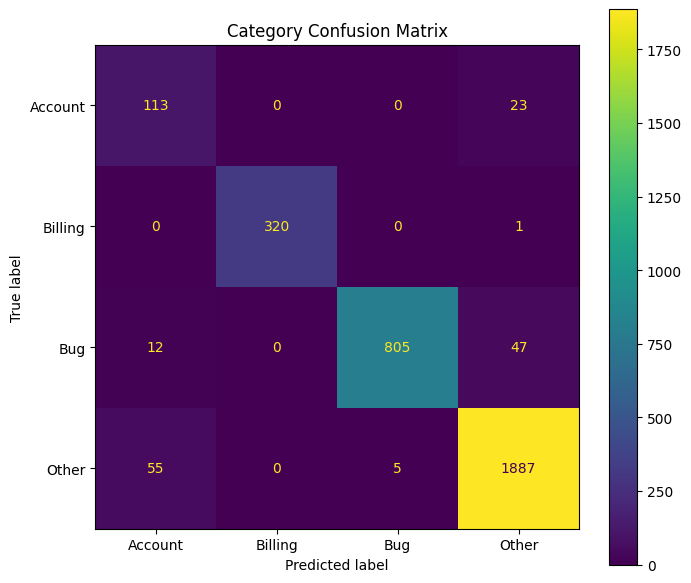

In [9]:
fig, ax = plt.subplots(figsize=(7.2, 6.2))
ConfusionMatrixDisplay.from_predictions(ycat_val, ycat_pred, ax=ax, values_format="d")
ax.set_title("Category Confusion Matrix")
plt.tight_layout()
plt.show()


### Error analysis — Category

Inspect a few misclassified examples to understand failure modes.


In [10]:
val_cat = X_val.copy()
val_cat["y_true"] = ycat_val.values
val_cat["y_pred"] = ycat_pred

wrong_cat = val_cat[val_cat["y_true"] != val_cat["y_pred"]].copy()
print("Misclassified (Category):", len(wrong_cat), "/", len(val_cat))

display(wrong_cat.sample(min(10, len(wrong_cat)), random_state=RANDOM_STATE)[
    ["queue","type","tags_str","body_len","n_tags","y_true","y_pred","message"]
].reset_index(drop=True))


Misclassified (Category): 143 / 3268


,queue,type,tags_str,body_len,n_tags,y_true,y_pred,message
0,Service Outages and Maintenance,Incident,Outage | Disruption | Performance | Maintenanc...,580,6,Bug,Other,Report on Unanticipated Service Interruption |...
1,Technical Support,Problem,Hardware | Performance | IT | Tech Support,484,4,Account,Other,Problem with KVM Switch | Facing intermittent ...
2,Sales and Pre-Sales,Problem,Performance | Network | Outage | Disruption,554,4,Bug,Other,Frequent Latency Issues on SaaS Platform Linke...
3,Technical Support,Incident,Outage | Disruption | Network | Performance | ...,526,5,Account,Other,Urgent Assistance Required for System Outage |...
4,Product Support,Incident,Feedback | IT | Tech Support,310,3,Account,Other,Digital Strategy Challenge | Facing difficulti...
5,IT Support,Problem,Security | Alert | IT | Tech Support,290,4,Other,Account,Alert for Data Breach | A data breach has been...
6,Returns and Exchanges,Incident,Hardware | Network | Performance | IT | Tech S...,563,5,Account,Other,Problem with Headset Connection | I'm having t...
7,Technical Support,Problem,Security | Outage | Performance | IT | Tech Su...,452,5,Account,Other,Experienced Data Breach Affecting Medical Data...
8,Product Support,Change,Performance | Feature | Feedback | IT | Tech S...,462,5,Bug,Other,Optimization of Data Analytics Tools | Regardi...
9,Technical Support,Incident,Security | Virus | IT | Tech Support | Alert,541,5,Other,Account,Support Needed for Potential Data Breach | We ...


## 8) Model #2 — Priority prediction (low / medium / high)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

priority_pipeline = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
])

priority_pipeline.fit(X_train, ypri_train)


ypri_pred = priority_pipeline.predict(X_val)
print("Priority (standard) F1-macro:", round(f1_score(ypri_val, ypri_pred, average="macro"), 4))
print("\nClassification report (standard):\n")
print(classification_report(ypri_val, ypri_pred))

# 3) Threshold tuning for HIGH (ops-focused)
proba = priority_pipeline.predict_proba(X_val)
classes = priority_pipeline.named_steps["clf"].classes_
high_idx = list(classes).index("high")
p_high = proba[:, high_idx]

# Try a few thresholds and pick what you like
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50]
best = None

for t in thresholds:
    y_adj = np.array(ypri_pred, dtype=object)      # start from standard predictions
    y_adj[p_high >= t] = "high"                    # force high when confidence is high

    f1m = f1_score(ypri_val, y_adj, average="macro")
    print(f"\n=== Threshold t={t:.2f} (force HIGH if P(high) >= t) ===")
    print("F1-macro:", round(f1m, 4))
    print(classification_report(ypri_val, y_adj))

    if best is None or f1m > best[0]:
        best = (f1m, t, y_adj)

print("\nBest threshold by F1-macro:", best[1], "with F1-macro:", round(best[0], 4))


Priority (standard) F1-macro: 0.6343

Classification report (standard):

              precision    recall  f1-score   support

        high       0.72      0.71      0.71      1332
         low       0.53      0.64      0.58       650
      medium       0.64      0.58      0.60      1286

    accuracy                           0.64      3268
   macro avg       0.63      0.64      0.63      3268
weighted avg       0.65      0.64      0.65      3268


=== Threshold t=0.30 (force HIGH if P(high) >= t) ===
F1-macro: 0.6025
              precision    recall  f1-score   support

        high       0.63      0.82      0.72      1332
         low       0.54      0.59      0.57       650
      medium       0.67      0.43      0.52      1286

    accuracy                           0.62      3268
   macro avg       0.62      0.62      0.60      3268
weighted avg       0.63      0.62      0.61      3268


=== Threshold t=0.35 (force HIGH if P(high) >= t) ===
F1-macro: 0.6286
              precisi

### Decision policy: Balanced vs. Safety (high-priority focus)

We evaluated two inference policies for priority prediction:

- **Balanced policy (default):** uses the model’s standard `argmax` prediction.  
  This setting provides the best overall balance across classes with **F1-macro = 0.63**.

- **Safety policy (ops-critical):** forces the label **HIGH** when the model confidence exceeds a threshold  
  (e.g., `P(high) ≥ 0.30`). This increases the ability to catch urgent tickets, improving  
  **recall(high) from 0.71 to 0.82**, but it also produces more **false positives** and reduces performance on
  **medium** priority (more medium tickets are escalated to high), leading to a lower **F1-macro = 0.60**.

**Operational interpretation:** threshold selection is a business decision. Lower thresholds reduce missed urgent
tickets (fewer false negatives on **high**) but increase alert volume and escalation workload (more false positives).
In practice, the threshold should be tuned to match the organization’s tolerance for missed incidents vs. alert fatigue.


### Confusion Matrix — Priority

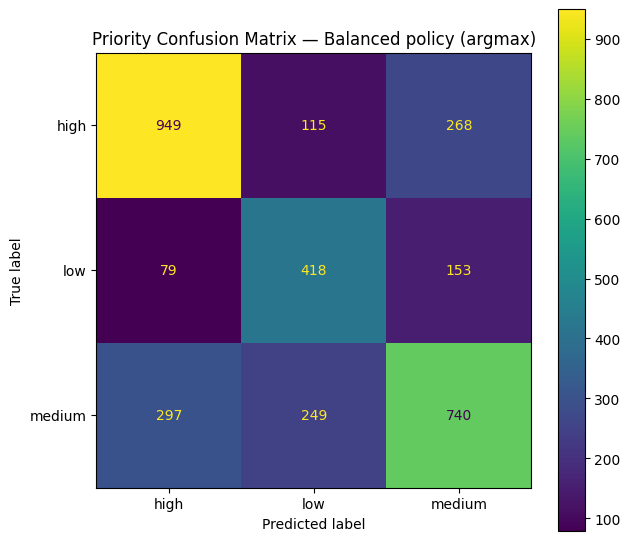

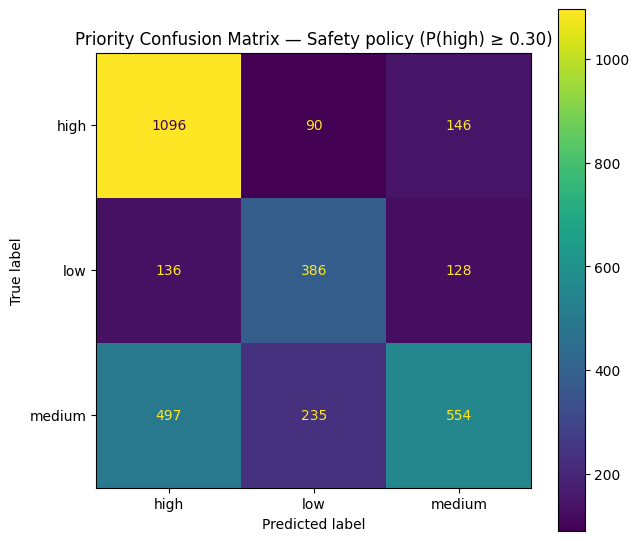

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Balanced (standard) ---
fig, ax = plt.subplots(figsize=(6.6, 5.8))
ConfusionMatrixDisplay.from_predictions(
    ypri_val, ypri_pred, ax=ax, values_format="d"
)
ax.set_title("Priority Confusion Matrix — Balanced policy (argmax)")
plt.tight_layout()
plt.show()

# --- 2) Safety (threshold) ---
t = 0.30  # change if needed
proba = priority_pipeline.predict_proba(X_val)
classes = list(priority_pipeline.named_steps["clf"].classes_)
high_idx = classes.index("high")
p_high = proba[:, high_idx]

ypri_safety = np.array(ypri_pred, dtype=object)
ypri_safety[p_high >= t] = "high"

fig, ax = plt.subplots(figsize=(6.6, 5.8))
ConfusionMatrixDisplay.from_predictions(
    ypri_val, ypri_safety, ax=ax, values_format="d"
)
ax.set_title(f"Priority Confusion Matrix — Safety policy (P(high) ≥ {t:.2f})")
plt.tight_layout()
plt.show()


### Error analysis — Priority (focus on `high`)

Operations often care most about high-priority tickets.


In [13]:
val_pri = X_val.copy()
val_pri["y_true"] = ypri_val.values
val_pri["y_pred"] = ypri_pred

wrong_pri = val_pri[val_pri["y_true"] != val_pri["y_pred"]].copy()
print("Misclassified (Priority):", len(wrong_pri), "/", len(val_pri))

high_related = wrong_pri[(wrong_pri["y_true"]=="high") | (wrong_pri["y_pred"]=="high")].copy()
print("High-related errors:", len(high_related))

display(high_related.sample(min(10, len(high_related)), random_state=RANDOM_STATE)[
    ["queue","type","tags_str","body_len","n_tags","y_true","y_pred","message"]
].reset_index(drop=True))


Misclassified (Priority): 1161 / 3268
High-related errors: 759


,queue,type,tags_str,body_len,n_tags,y_true,y_pred,message
0,Service Outages and Maintenance,Change,Disruption | Performance | IT | Tech Support,111,4,medium,high,Report on Service Disruptions | Service disrup...
1,Technical Support,Incident,Performance | Outage | Disruption | Recovery |...,206,6,medium,high,Data Analytics Platform | The investment optim...
2,Technical Support,Request,Feature | Documentation | IT | Tech Support,289,4,high,medium,Support for Integrating Jenkins | I am trying ...
3,Billing and Payments,Request,Feature | Feedback | IT | Tech Support,60,4,high,low,Query Regarding Data Analytics Services | Is i...
4,Product Support,Problem,Performance | Outage | Disruption | Recovery |...,467,6,high,medium,Issue with Financial Firm's Investment Data Pr...
5,Service Outages and Maintenance,Incident,Performance | Outage | Disruption | Recovery |...,178,6,low,high,Concerns About System Performance | There was ...
6,Technical Support,Problem,Security | Data Breach | Confidentiality | Out...,533,6,medium,high,"Dear Customer Support,\n\nI am reaching out to..."
7,Sales and Pre-Sales,Request,Security | Data Privacy | Healthcare | HIPAA |...,614,7,high,medium,Ensuring Security in Medical Data Solutions | ...
8,Billing and Payments,Incident,Billing | Payment | Refund | Support | Documen...,282,6,high,medium,Support Request for Clarifying Billing Discrep...
9,Product Support,Problem,Security | IT | Tech Support,80,3,high,medium,Recent unauthorized access to medical data sys...


## 9) Save artifacts (pipelines)

These artifacts are directly usable for:
- FastAPI endpoints (predict category/priority)
- batch scoring (daily monitoring)


In [14]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

cat_path = os.path.join(MODEL_DIR, "t4_category_pipeline.joblib")
pri_path = os.path.join(MODEL_DIR, "t4_priority_pipeline.joblib")

joblib.dump(category_pipeline, cat_path)
joblib.dump(priority_pipeline, pri_path)

print("Saved:", cat_path)
print("Saved:", pri_path)


Saved: models\t4_category_pipeline.joblib
Saved: models\t4_priority_pipeline.joblib


## 10) Portfolio-ready summary (fill after running)

After execution, fill this section with your real numbers:

- EN tickets: **{n}**
- Dummy baselines:
  - Category F1-macro: **...**
  - Priority F1-macro: **...**
- Improved baselines:
  - Category F1-macro: **...**
  - Priority F1-macro: **...**
- Key observations:
  - Most category confusions: **...**
  - High-priority errors mostly occur in: **... queues**
- Next improvements (T5):
  - probability calibration + thresholds (especially for `high`)
  - add time-based features if available (ticket volume monitoring)
  - transformer baseline (MiniLM/DistilBERT) + fine-tuning
